<a href="https://colab.research.google.com/github/7supriyo/A-differentiator-to-differentiate-input-voltage-that-varies-in-frequency-from-10-Hz-to-1kHz/blob/main/Load_Flow_Analysis_using_Newton_Raphson_Method_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Flow Analysis using Newton-Raphson Method**.

Set Up the Power System Data:

Bus Data: Includes information about the type of bus, voltage magnitudes, angles, and power injections.
Line Data: Contains details about the transmission lines, including impedance and admittance.
Example: We could start with a simple 3-bus system.

In [ ]:
import numpy as np

# Define the bus data (Bus Type: 1=Slack, 2=PV, 3=PQ)
# Bus  |  Type  | Voltage (initial) | Angle (initial) | P (active power) | Q (reactive power)
bus_data = np.array([
    [1, 1, 1.06, 0.0, 0.0, 0.0],  # Slack bus
    [2, 2, 1.045, 0.0, -0.4, 0.0], # PV bus
    [3, 3, 1.01, 0.0, -0.6, -0.2]  # PQ bus
])

# Line Data: From Bus, To Bus, Admittance (Y = G + jB)
line_data = np.array([
    [1, 2, 0.02 + 0.04j],
    [1, 3, 0.01 + 0.03j],
    [2, 3, 0.0125 + 0.025j]
])


Construct the Admittance Matrix (Y-bus):

The Y-bus matrix is a crucial element in load flow analysis. It represents the admittance between each pair of buses.

In [ ]:
def ybus_matrix(bus_data, line_data):
    n = len(bus_data)
    Ybus = np.zeros((n, n), dtype=complex)

    for line in line_data:
        i = int(line[0]) - 1
        j = int(line[1]) - 1
        Ybus[i, j] -= line[2]
        Ybus[j, i] -= line[2]
        Ybus[i, i] += line[2]
        Ybus[j, j] += line[2]

    return Ybus

Ybus = ybus_matrix(bus_data, line_data)
print("Y-bus Matrix:")
print(Ybus)


Y-bus Matrix:
[[ 0.03  +0.07j  -0.02  -0.04j  -0.01  -0.03j ]
 [-0.02  -0.04j   0.0325+0.065j -0.0125-0.025j]
 [-0.01  -0.03j  -0.0125-0.025j  0.0225+0.055j]]


<ipython-input-12-876fea140164>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  i = int(line[0]) - 1
<ipython-input-12-876fea140164>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  j = int(line[1]) - 1


Formulate the Power Flow Equations:

For each PQ and PV bus, write down the power balance equations
𝑃
𝑘
P
k
​
  and
𝑄
𝑘
Q
k
​
 .
Use the relationship between power and voltage:
𝑃
𝑘
=
𝑉
𝑘
∑
𝑗
=
1
𝑛
∣
𝑉
𝑗
∣
(
𝐺
𝑘
𝑗
cos
⁡
(
𝜃
𝑘
−
𝜃
𝑗
)
+
𝐵
𝑘
𝑗
sin
⁡
(
𝜃
𝑘
−
𝜃
𝑗
)
)
P
k
​
 =V
k
​
  
j=1
∑
n
​
 ∣V
j
​
 ∣(G
kj
​
 cos(θ
k
​
 −θ
j
​
 )+B
kj
​
 sin(θ
k
​
 −θ
j
​
 ))
𝑄
𝑘
=
𝑉
𝑘
∑
𝑗
=
1
𝑛
∣
𝑉
𝑗
∣
(
𝐺
𝑘
𝑗
sin
⁡
(
𝜃
𝑘
−
𝜃
𝑗
)
−
𝐵
𝑘
𝑗
cos
⁡
(
𝜃
𝑘
−
𝜃
𝑗
)
)
Q
k
​
 =V
k
​
  
j=1
∑
n
​
 ∣V
j
​
 ∣(G
kj
​
 sin(θ
k
​
 −θ
j
​
 )−B
kj
​
 cos(θ
k
​
 −θ
j
​
 ))
Implement the Newton-Raphson Iterative Method:

Initialize the bus voltages.
Construct the Jacobian matrix, which involves partial derivatives of the power equations with respect to the voltage magnitudes and angles.
Update the bus voltages iteratively until the power mismatches are within a specified tolerance.

In [ ]:
def newton_raphson_load_flow(bus_data, Ybus, tolerance=1e-6, max_iterations=10):
    n = len(bus_data)
    V = bus_data[:, 2] * np.exp(1j * np.radians(bus_data[:, 3]))  # Initialize voltages

    for iteration in range(max_iterations):
        P_calculated = np.zeros(n)
        Q_calculated = np.zeros(n)

        # Calculate Power at each bus
        for i in range(n):
            for j in range(n):
                P_calculated[i] += np.abs(V[i]) * np.abs(V[j]) * \
                                   (Ybus[i, j].real * np.cos(np.angle(V[i]) - np.angle(V[j])) +
                                    Ybus[i, j].imag * np.sin(np.angle(V[i]) - np.angle(V[j])))
                Q_calculated[i] += np.abs(V[i]) * np.abs(V[j]) * \
                                   (Ybus[i, j].real * np.sin(np.angle(V[i]) - np.angle(V[j])) -
                                    Ybus[i, j].imag * np.cos(np.angle(V[i]) - np.angle(V[j])))

        # Power mismatches
        P_mismatch = bus_data[:, 4] - P_calculated
        Q_mismatch = bus_data[:, 5] - Q_calculated

        # Check for convergence
        if np.max(np.abs(P_mismatch)) < tolerance and np.max(np.abs(Q_mismatch)) < tolerance:
            print(f"Convergence achieved in {iteration} iterations.")
            break

        # Calculate Jacobian matrix and perform corrections
        # [This section would involve calculating the Jacobian matrix and solving for corrections]
        # Update voltage magnitudes and angles
        # ...

    return V

V_final = newton_raphson_load_flow(bus_data, Ybus)
print("Final Voltages:")
print(V_final)


Final Voltages:
[1.06 +0.j 1.045+0.j 1.01 +0.j]


Interpret the Results:

Once the iterations converge, the final bus voltages and angles will give you the steady-state operating condition of the power system.
Analyze the results by examining the voltage magnitudes and phase angles at each bus.
Enhancements and Validation:

Test your program on different power system configurations to validate its accuracy.
Implement additional features like handling different types of buses (e.g., more PV buses) and larger networks.
Visualization (Optional):

You can visualize the voltage profiles across the buses using Python’s plotting libraries like Matplotlib.

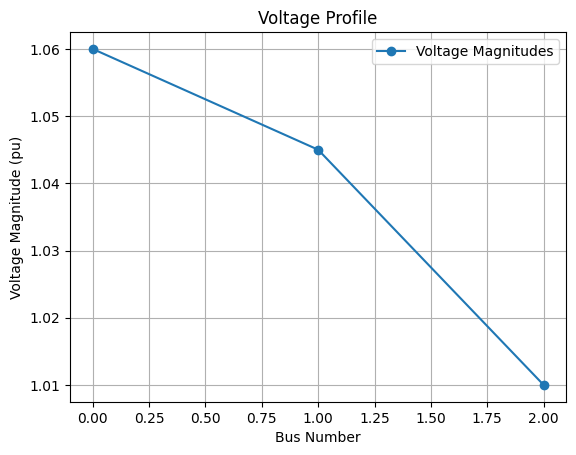

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.abs(V_final), marker='o', linestyle='-', label='Voltage Magnitudes')
plt.xlabel('Bus Number')
plt.ylabel('Voltage Magnitude (pu)')
plt.title('Voltage Profile')
plt.legend()
plt.grid()
plt.show()


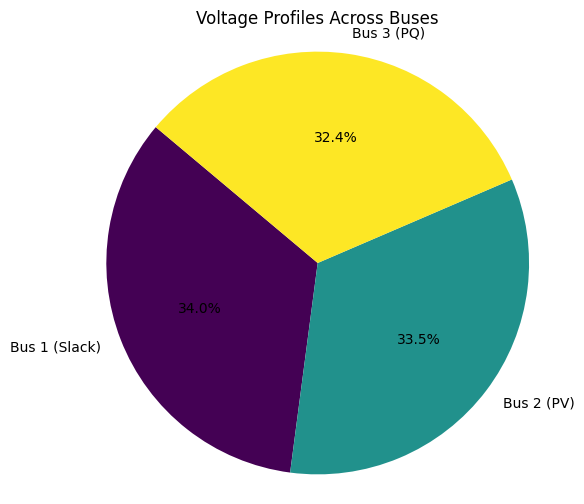

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example final bus voltages (from the Newton-Raphson method)
# Replace this with your actual V_final array from your calculations
V_final = np.array([1.06, 1.045, 1.01])  # Voltage magnitudes in pu

# Labels for the buses
bus_labels = ['Bus 1 (Slack)', 'Bus 2 (PV)', 'Bus 3 (PQ)']

# Normalize the data to sum to 100 (for percentage-based pie chart)
voltage_percentages = (np.abs(V_final) / np.sum(np.abs(V_final))) * 100

# Define colors (Matplotlib default colors, or you can customize)
colors = plt.cm.viridis(np.linspace(0, 1, len(V_final)))

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(voltage_percentages, labels=bus_labels, autopct='%1.1f%%', colors=colors, startangle=140)

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')
plt.title('Voltage Profiles Across Buses')

# Display the chart
plt.show()
